# Imports the Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
import joblib

warnings.filterwarnings('ignore')


# Loading the data & exploring dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_and_explore_data(file_path):
    """
    Step 1: Load the CKD dataset and display basic info.
    """
    # Load dataset
    df = pd.read_csv("/content/kidney_disease.csv")

    print(" Dataset Loaded Successfully!\n")
    print(" First 5 rows of data:\n", df.head(), "\n")

    # Dataset info
    print(" Dataset Info:")
    print(f"- Shape: {df.shape}")
    print(f"- Rows: {df.shape[0]}")
    print(f"- Columns: {df.shape[1]}")
    print(f"- Features (excluding target): {df.shape[1] - 1}\n")

    print(" Data Types:\n", df.dtypes, "\n")
    print(" Summary Statistics:\n", df.describe().transpose())

    return df


# Step 1: Load & explore data
df = load_and_explore_data("kidney_disease.csv")

 Dataset Loaded Successfully!

 First 5 rows of data:
    id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

   ...  pcv    wc   rc  htn   dm  cad appet   pe  ane classification  
0  ...   44  7800  5.2  yes  yes   no  good   no   no            ckd  
1  ...   38  6000  NaN   no   no   no  good   no   no            ckd  
2  ...   31  7500  NaN   no  yes   no  poor   no  yes            ckd  
3  ...   32  6700  3.9  yes   no   no  poor  yes  yes            ckd  
4  ...   35  7300  4.6   no   no   no  good   no   no            ckd  

[5 rows x 26 columns] 

 Dataset Info

# Renaming the column names + missing values information

In [4]:
def clean_and_missing_values(df):
    """
    Step 2: Rename columns and check missing values.
    Returns cleaned DataFrame and Missing Value Summary.
    """
    # Rename columns
    df.columns = [
        'ID', 'Age', 'Blood_Pressure', 'Specific_Gravity', 'Albumin', 'Sugar',
        'Red_Blood_Cells', 'Pus_Cell', 'Pus_Cell_Clumps', 'Bacteria',
        'Blood_Glucose_Random', 'Blood_Urea', 'Serum_Creatinine', 'Sodium',
        'Potassium', 'Hemoglobin', 'Packed_Cell_Volume', 'White_Blood_Cell_Count',
        'Red_Blood_Cell_Count', 'Hypertension', 'Diabetes_Mellitus', 'Coronary_Artery_Disease',
        'Appetite', 'Pedal_Edema', 'Anemia', 'Classification'
    ]

    # Missing values summary
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data / len(df)) * 100

    missing_df = pd.DataFrame({
        'Column Name': df.columns,
        'Missing Count': missing_data.values,
        'Missing Percentage': missing_percentage.values
    }).sort_values('Missing Percentage', ascending=False).reset_index(drop=True)

    print("\nMissing Values Summary:\n", missing_df)

    return df, missing_df


# Step 2: Clean column names + missing values
CKD_Data, missing_summary = clean_and_missing_values(df)


Missing Values Summary:
                 Column Name  Missing Count  Missing Percentage
0           Red_Blood_Cells            152               38.00
1      Red_Blood_Cell_Count            130               32.50
2    White_Blood_Cell_Count            105               26.25
3                 Potassium             88               22.00
4                    Sodium             87               21.75
5        Packed_Cell_Volume             70               17.50
6                  Pus_Cell             65               16.25
7                Hemoglobin             52               13.00
8                     Sugar             49               12.25
9          Specific_Gravity             47               11.75
10                  Albumin             46               11.50
11     Blood_Glucose_Random             44               11.00
12               Blood_Urea             19                4.75
13         Serum_Creatinine             17                4.25
14           Blood_Pressure  

# Visualizing some EDA plots (Before Data Cleaning)

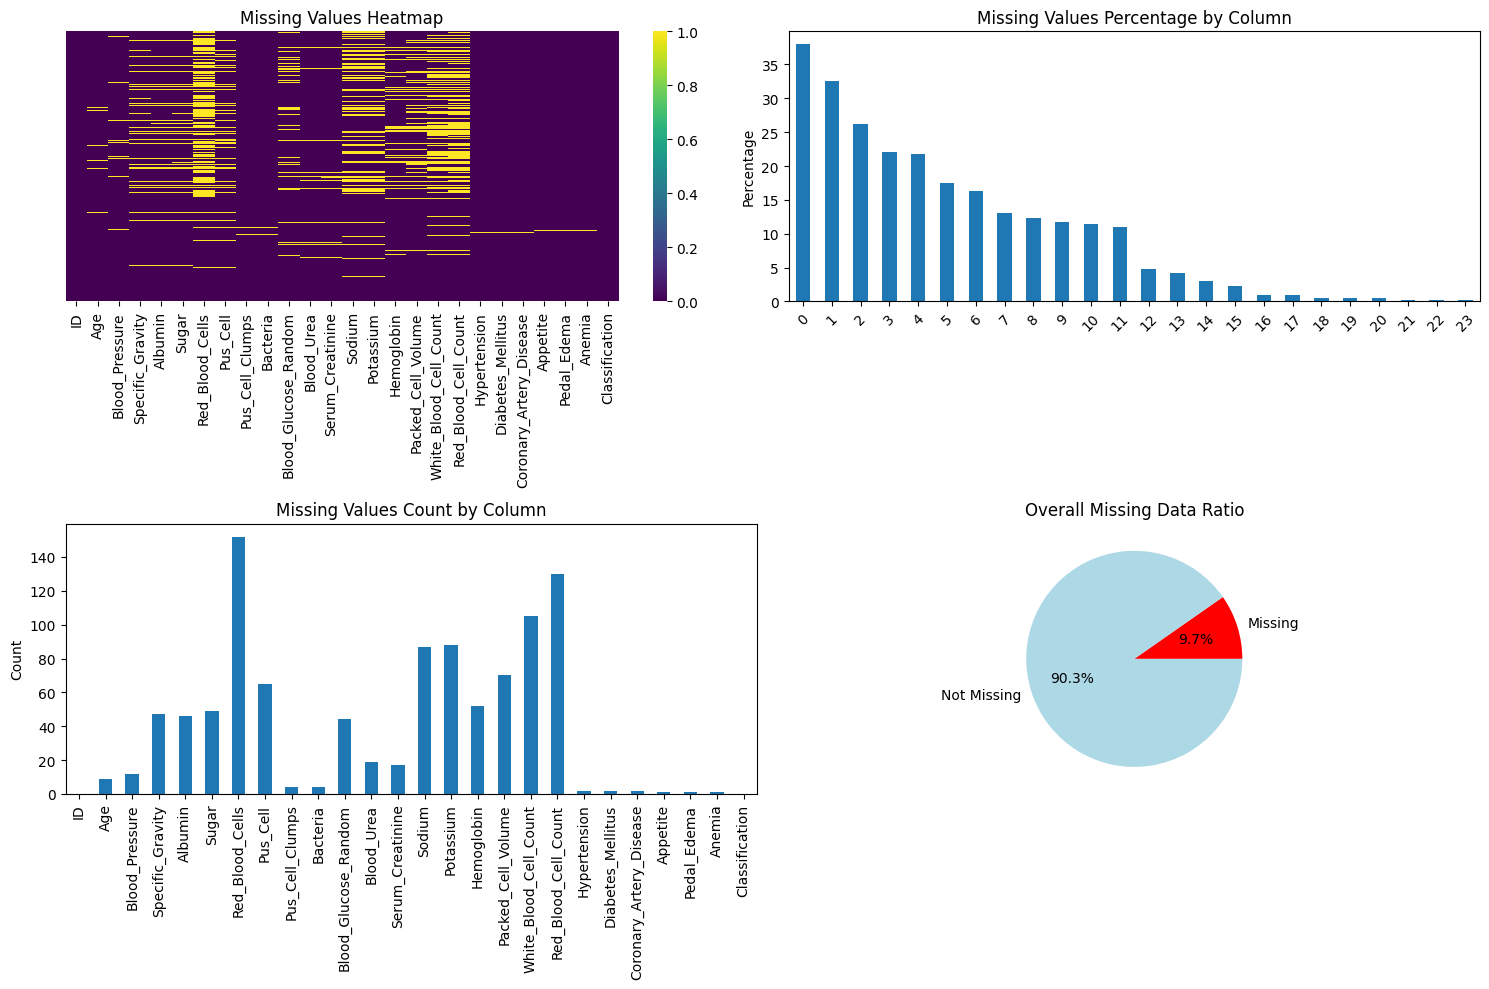

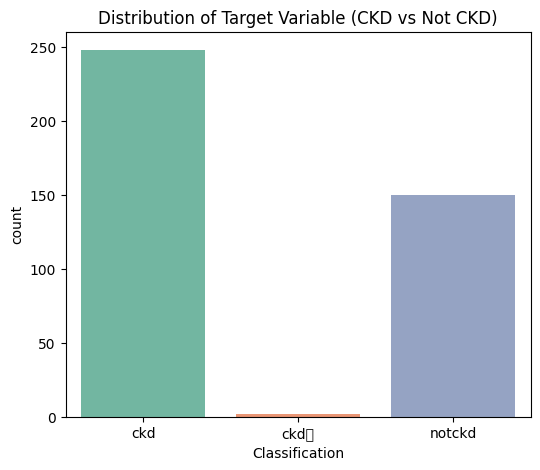

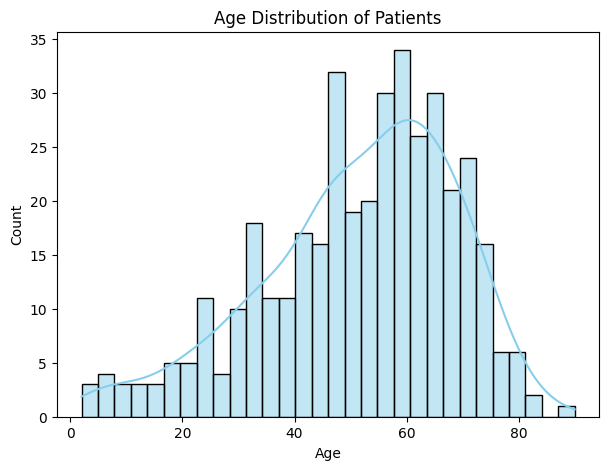

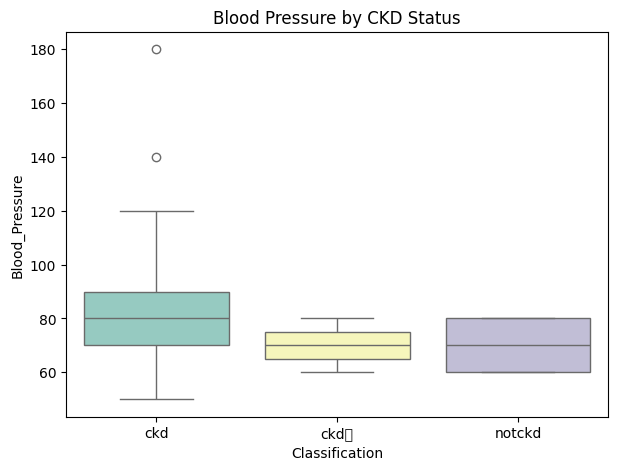

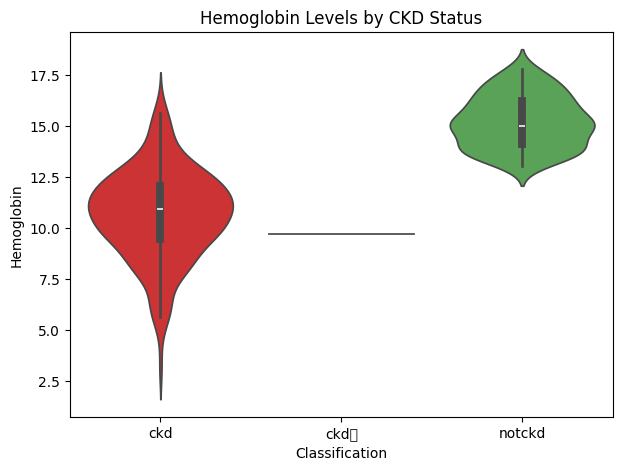

In [5]:
def visualize_data(df, missing_df):
    """
    Step 3: Generate missing values plots and some EDA plots.
    """
    # Missing Values Visualization
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.heatmap(df.isnull(), yticklabels=False, cbar=True, cmap='viridis')
    plt.title('Missing Values Heatmap')

    plt.subplot(2, 2, 2)
    missing_counts = missing_df[missing_df['Missing Count'] > 0]['Missing Percentage']
    missing_counts.plot(kind='bar')
    plt.title('Missing Values Percentage by Column')
    plt.ylabel('Percentage')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 3)
    df.isnull().sum().plot(kind='bar')
    plt.title('Missing Values Count by Column')
    plt.ylabel('Count')
    plt.xticks(rotation=90)

    plt.subplot(2, 2, 4)
    total_missing = df.isnull().sum().sum()
    total_cells = np.prod(df.shape)
    plt.pie([total_missing, total_cells - total_missing],
            labels=['Missing', 'Not Missing'],
            autopct='%1.1f%%',
            colors=['red', 'lightblue'])
    plt.title('Overall Missing Data Ratio')

    plt.tight_layout()
    plt.show()

    # Target Variable Distribution
    plt.figure(figsize=(6,5))
    sns.countplot(x="Classification", data=df, palette="Set2")
    plt.title("Distribution of Target Variable (CKD vs Not CKD)")
    plt.show()

    # Age Distribution
    plt.figure(figsize=(7,5))
    sns.histplot(df["Age"].dropna(), bins=30, kde=True, color="skyblue")
    plt.title("Age Distribution of Patients")
    plt.show()

    # Blood Pressure vs CKD
    plt.figure(figsize=(7,5))
    sns.boxplot(x="Classification", y="Blood_Pressure", data=df, palette="Set3")
    plt.title("Blood Pressure by CKD Status")
    plt.show()

    # Hemoglobin vs CKD
    plt.figure(figsize=(7,5))
    sns.violinplot(x="Classification", y="Hemoglobin", data=df, palette="Set1")
    plt.title("Hemoglobin Levels by CKD Status")
    plt.show()


# Step 3: Visualize data
visualize_data(CKD_Data, missing_summary)

# Data Cleaning

In [6]:
def clean_nonstandard_values(df):
    """
    Cleans non-standard values in CKD dataset.
    - Replaces '\t?', '\tyes', '\tno', ' yes', 'ckd\t' etc.
    - Shows unique values before and after cleaning.
    """
    print("\n Checking non-standard values before cleaning:\n")
    for col in df.columns:
        if df[col].dtype == 'object':  # only categorical/text columns
            print(f"{col}: {df[col].unique()}")

    # Step 1: Replace universal weird characters with NaN
    df.replace({'\t?': np.nan}, inplace=True)

    # Step 2: Fix Classification column
    if 'Classification' in df.columns:
        df['Classification'] = df['Classification'].str.replace('ckd\t', 'ckd', regex=False)

    # Step 3: Fix Diabetes Mellitus column
    if 'Diabetes_Mellitus' in df.columns:
        df['Diabetes_Mellitus'].replace(
            to_replace={'\tno': 'no', '\tyes': 'yes', ' yes': 'yes'}, inplace=True
        )

    # Step 4: Fix Coronary Artery Disease column
    if 'Coronary_Artery_Disease' in df.columns:
        df['Coronary_Artery_Disease'].replace(
            to_replace={'\tno': 'no'}, inplace=True
        )

    print("\n Cleaning done!\n")
    print(" Checking unique values after cleaning:\n")
    for col in df.columns:
        if df[col].dtype == 'object':
            print(f"{col}: {df[col].unique()}")

    return df

CKD_Data = clean_nonstandard_values(CKD_Data)


 Checking non-standard values before cleaning:

Red_Blood_Cells: [nan 'normal' 'abnormal']
Pus_Cell: ['normal' 'abnormal' nan]
Pus_Cell_Clumps: ['notpresent' 'present' nan]
Bacteria: ['notpresent' 'present' nan]
Packed_Cell_Volume: ['44' '38' '31' '32' '35' '39' '36' '33' '29' '28' nan '16' '24' '37' '30'
 '34' '40' '45' '27' '48' '\t?' '52' '14' '22' '18' '42' '17' '46' '23'
 '19' '25' '41' '26' '15' '21' '43' '20' '\t43' '47' '9' '49' '50' '53'
 '51' '54']
White_Blood_Cell_Count: ['7800' '6000' '7500' '6700' '7300' nan '6900' '9600' '12100' '4500'
 '12200' '11000' '3800' '11400' '5300' '9200' '6200' '8300' '8400' '10300'
 '9800' '9100' '7900' '6400' '8600' '18900' '21600' '4300' '8500' '11300'
 '7200' '7700' '14600' '6300' '\t6200' '7100' '11800' '9400' '5500' '5800'
 '13200' '12500' '5600' '7000' '11900' '10400' '10700' '12700' '6800'
 '6500' '13600' '10200' '9000' '14900' '8200' '15200' '5000' '16300'
 '12400' '\t8400' '10500' '4200' '4700' '10900' '8100' '9500' '2200'
 '12800' '1

In [7]:
def check_column_types(df, target_col=None):
    """
    Function to check numerical and categorical columns in a dataset.

    Parameters:
        df (pd.DataFrame): Input dataframe
        target_col (str): Target column to exclude (e.g., 'class' or 'Classification')

    Returns:
        numerical_columns (list): List of numerical column names
        categorical_columns (list): List of categorical column names
    """
    # Select column types
    numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

    # Optionally exclude target column
    if target_col:
        if target_col in numerical_columns:
            numerical_columns.remove(target_col)
        if target_col in categorical_columns:
            categorical_columns.remove(target_col)

    # Print results
    print("\n Column Type Summary: ")
    print(f"Numerical columns ({len(numerical_columns)}): {numerical_columns}")
    print(f"Categorical columns ({len(categorical_columns)}): {categorical_columns}")

    return numerical_columns, categorical_columns


num_cols, cat_cols = check_column_types(CKD_Data, target_col="Classification")



 Column Type Summary: 
Numerical columns (12): ['ID', 'Age', 'Blood_Pressure', 'Specific_Gravity', 'Albumin', 'Sugar', 'Blood_Glucose_Random', 'Blood_Urea', 'Serum_Creatinine', 'Sodium', 'Potassium', 'Hemoglobin']
Categorical columns (13): ['Red_Blood_Cells', 'Pus_Cell', 'Pus_Cell_Clumps', 'Bacteria', 'Packed_Cell_Volume', 'White_Blood_Cell_Count', 'Red_Blood_Cell_Count', 'Hypertension', 'Diabetes_Mellitus', 'Coronary_Artery_Disease', 'Appetite', 'Pedal_Edema', 'Anemia']


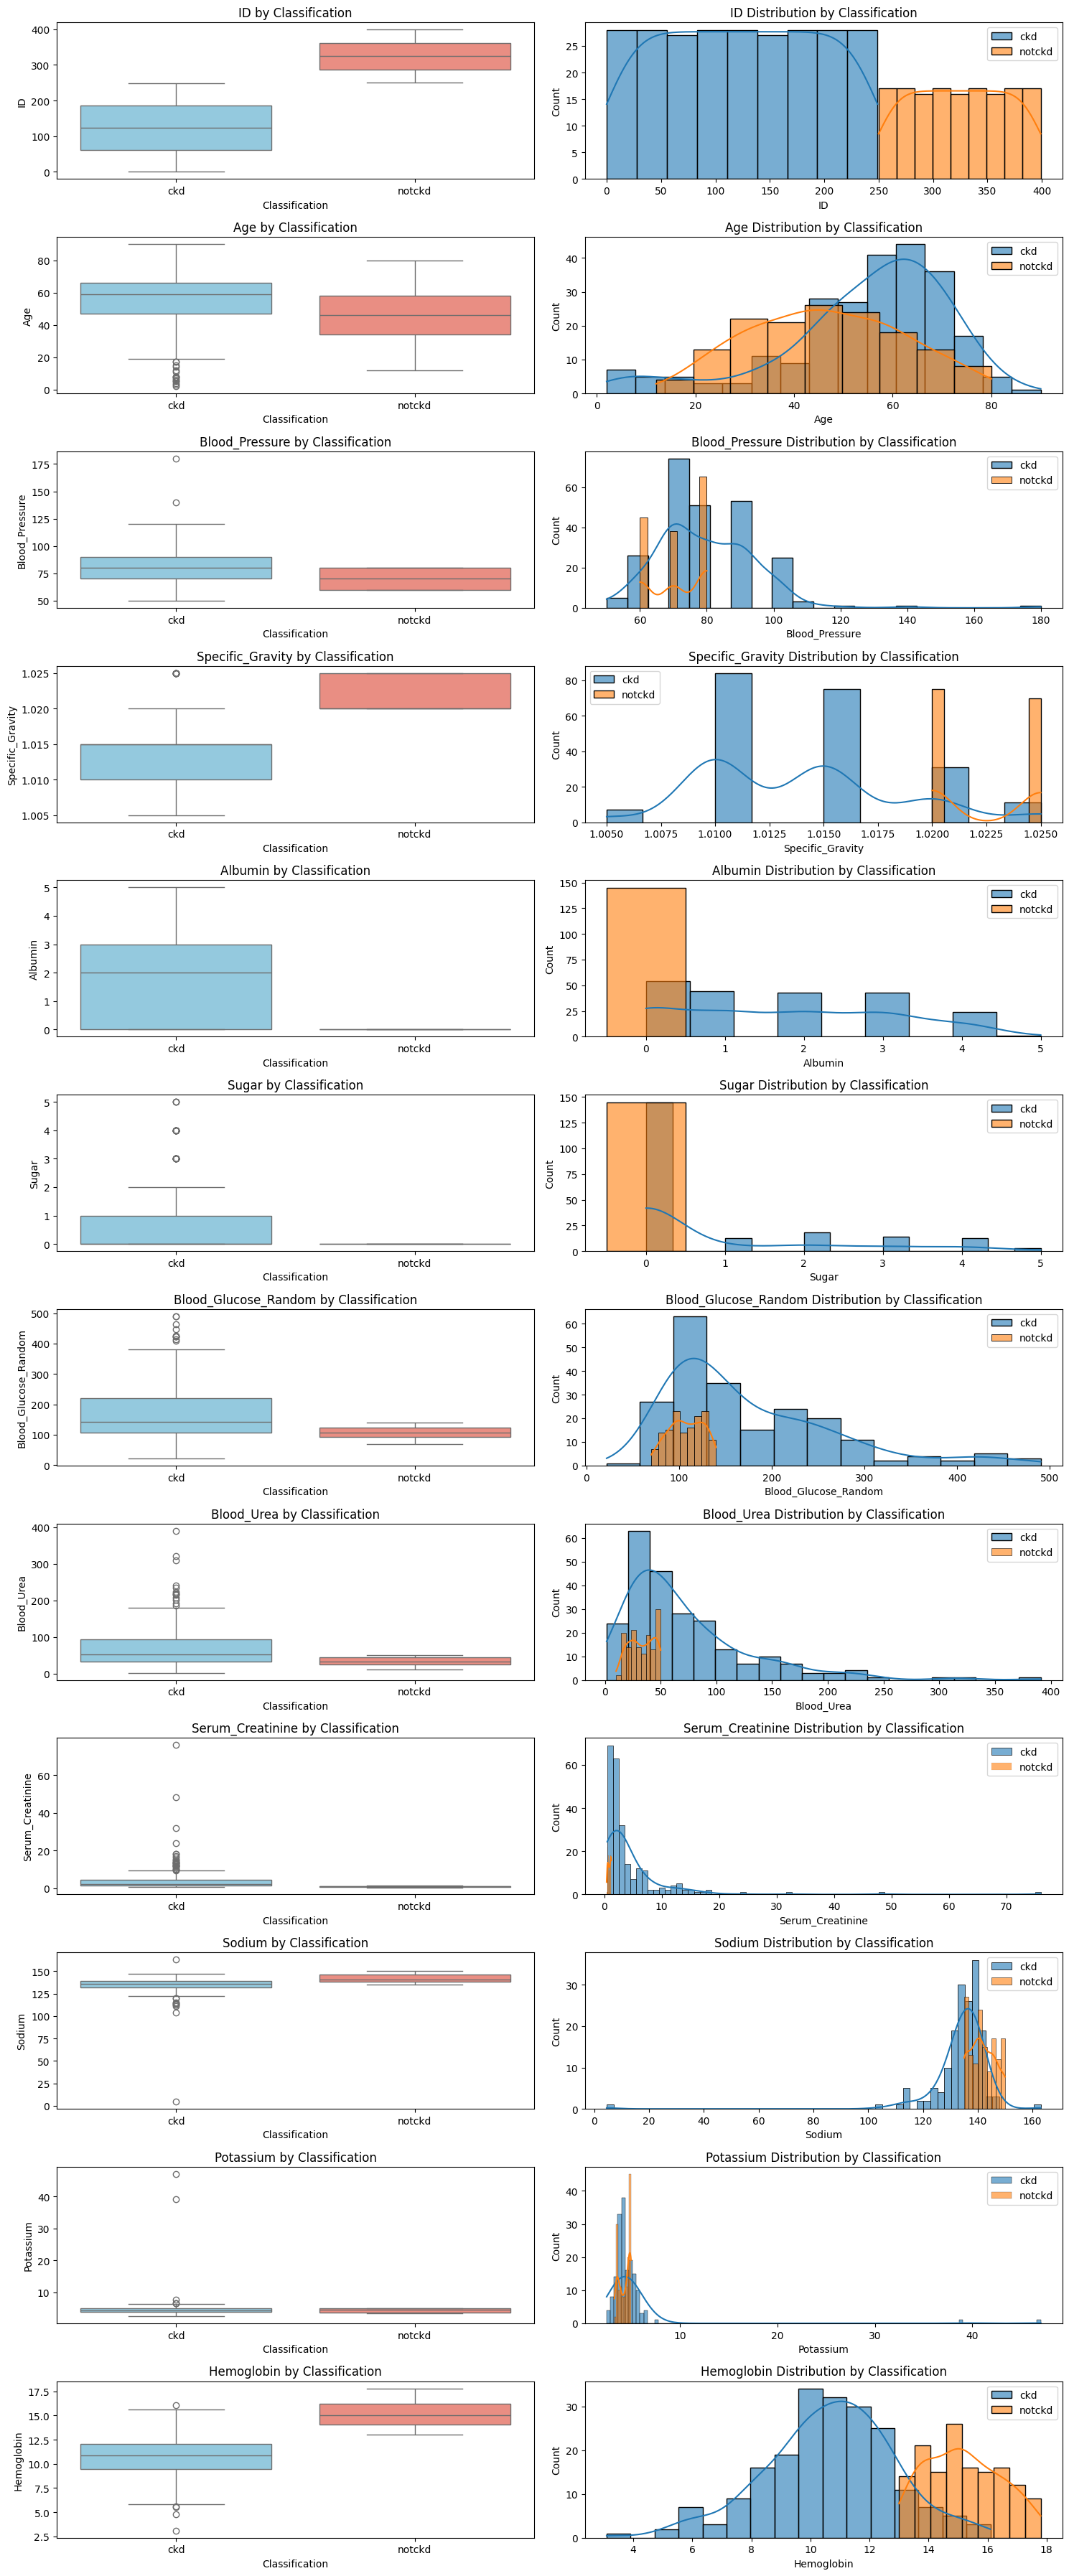

In [8]:
def plot_numerical_features(df, numerical_columns, target_col="Classification"):
    """
    Plots boxplots and histograms for numerical features grouped by target column.

    Parameters:
        df (pd.DataFrame): Input dataframe
        numerical_columns (list): List of numerical column names
        target_col (str): Target column name (default='Classification')
    """
    plt.figure(figsize=(15, len(numerical_columns) * 3))

    for i, col in enumerate(numerical_columns, 1):
        # Boxplot by classification
        plt.subplot(len(numerical_columns), 2, i*2-1)
        sns.boxplot(x=target_col, y=col, data=df.dropna(subset=[col]), palette=['skyblue', 'salmon'])
        plt.title(f'{col} by {target_col}')

        # Histogram by classification
        plt.subplot(len(numerical_columns), 2, i*2)
        for class_name in df[target_col].dropna().unique():
            sns.histplot(df[df[target_col] == class_name][col].dropna(),
                         label=class_name, alpha=0.6, kde=True)
        plt.title(f'{col} Distribution by {target_col}')
        plt.legend()

    plt.tight_layout()
    plt.show()


plot_numerical_features(CKD_Data, num_cols, target_col="Classification")


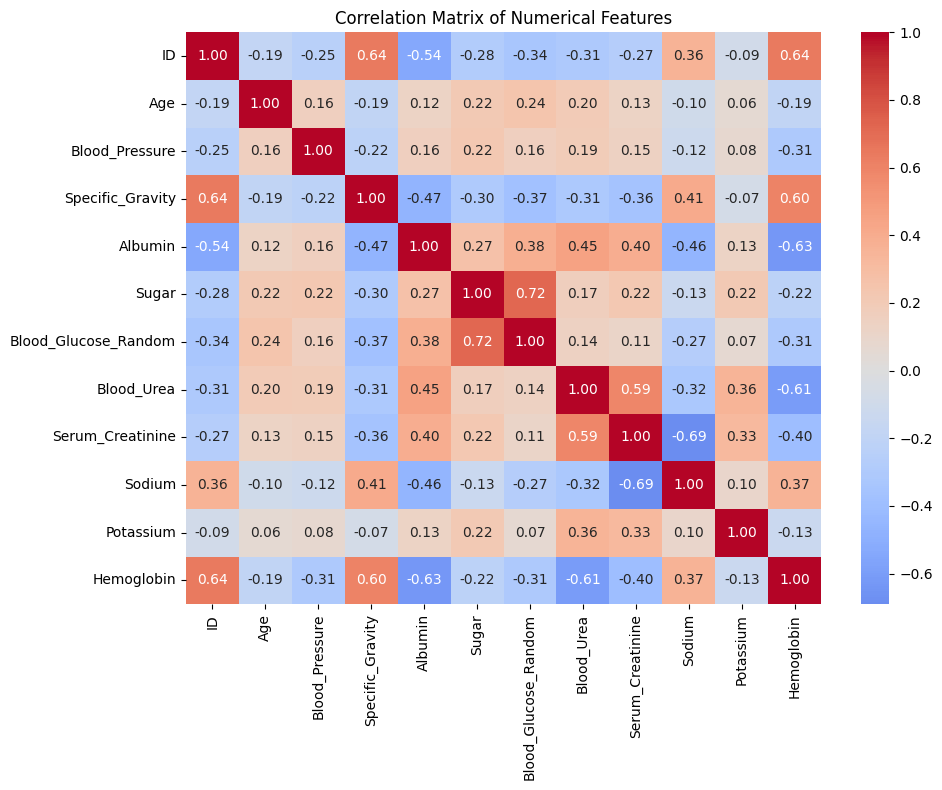

In [9]:
def plot_correlation_matrix(df, numerical_columns):
    """
    Plots the correlation matrix heatmap for numerical features.

    Parameters:
        df (pd.DataFrame): Input dataframe
        numerical_columns (list): List of numerical column names
    """
    # Compute correlation matrix
    corr_matrix = df[numerical_columns].corr()

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(CKD_Data, num_cols)


# Data preprocessing

 ## missing values imputation

In [10]:
def impute_missing_values(df, numerical_columns, categorical_columns):
    """
    Impute missing values for numerical (mean) and categorical (mode).
    Also returns missing values summary after imputation.
    """
    df_copy = df.copy()

    # Numerical  mean imputation
    num_imputer = SimpleImputer(strategy="mean")
    df_copy[numerical_columns] = num_imputer.fit_transform(df_copy[numerical_columns])

    # Categorical  most frequent imputation
    cat_imputer = SimpleImputer(strategy="most_frequent")
    df_copy[categorical_columns] = cat_imputer.fit_transform(df_copy[categorical_columns])

    # Missing value summary after imputation
    missing_after = df_copy.isnull().sum()
    missing_summary = pd.DataFrame({
        "Missing Count": missing_after,
        "Missing Percentage": (missing_after / len(df_copy)) * 100
    })

    print(" Missing values imputed. Here is the summary:\n")
    print(missing_summary)

    return df_copy, missing_summary


df_imputed, missing_summary = impute_missing_values(CKD_Data, num_cols, cat_cols)


 Missing values imputed. Here is the summary:

                         Missing Count  Missing Percentage
ID                                   0                 0.0
Age                                  0                 0.0
Blood_Pressure                       0                 0.0
Specific_Gravity                     0                 0.0
Albumin                              0                 0.0
Sugar                                0                 0.0
Red_Blood_Cells                      0                 0.0
Pus_Cell                             0                 0.0
Pus_Cell_Clumps                      0                 0.0
Bacteria                             0                 0.0
Blood_Glucose_Random                 0                 0.0
Blood_Urea                           0                 0.0
Serum_Creatinine                     0                 0.0
Sodium                               0                 0.0
Potassium                            0                 0.0
Hemoglobi

# Encoding categorical variables

In [11]:
def encode_categorical(df, categorical_columns):
    """
    Encode categorical variables using Label Encoding.
    Shows before/after encoding summary.
    """
    df_copy = df.copy()
    encoders = {}
    summary = {}

    for col in categorical_columns:
        le = LabelEncoder()

        # Save unique before encoding
        before = df_copy[col].unique()

        # Encode
        df_copy[col] = le.fit_transform(df_copy[col])
        encoders[col] = le

        # Save unique after encoding
        after = df_copy[col].unique()

        summary[col] = {
            "Before Encoding (unique values)": before,
            "After Encoding (unique values)": after
        }

    print(" Encoding completed. Summary of changes:\n")
    for col, details in summary.items():
        print(f"\nColumn: {col}")
        print(f"- Before: {details['Before Encoding (unique values)']}")
        print(f"- After : {details['After Encoding (unique values)']}")

    return df_copy, encoders


df_encoded, encoders = encode_categorical(df_imputed, cat_cols)


 Encoding completed. Summary of changes:


Column: Red_Blood_Cells
- Before: ['normal' 'abnormal']
- After : [1 0]

Column: Pus_Cell
- Before: ['normal' 'abnormal']
- After : [1 0]

Column: Pus_Cell_Clumps
- Before: ['notpresent' 'present']
- After : [0 1]

Column: Bacteria
- Before: ['notpresent' 'present']
- After : [0 1]

Column: Packed_Cell_Volume
- Before: ['44' '38' '31' '32' '35' '39' '36' '33' '29' '28' '41' '16' '24' '37'
 '30' '34' '40' '45' '27' '48' '52' '14' '22' '18' '42' '17' '46' '23'
 '19' '25' '26' '15' '21' '43' '20' '\t43' '47' '9' '49' '50' '53' '51'
 '54']
- After : [31 25 18 19 22 26 23 20 16 15 28  3 11 24 17 21 27 32 14 35 39  1  9  5
 29  4 33 10  6 12 13  2  8 30  7  0 34 42 36 37 40 38 41]

Column: White_Blood_Cell_Count
- Before: ['7800' '6000' '7500' '6700' '7300' '9800' '6900' '9600' '12100' '4500'
 '12200' '11000' '3800' '11400' '5300' '9200' '6200' '8300' '8400' '10300'
 '9100' '7900' '6400' '8600' '18900' '21600' '4300' '8500' '11300' '7200'
 '7700' '1

# Detecting  and treating  outliers

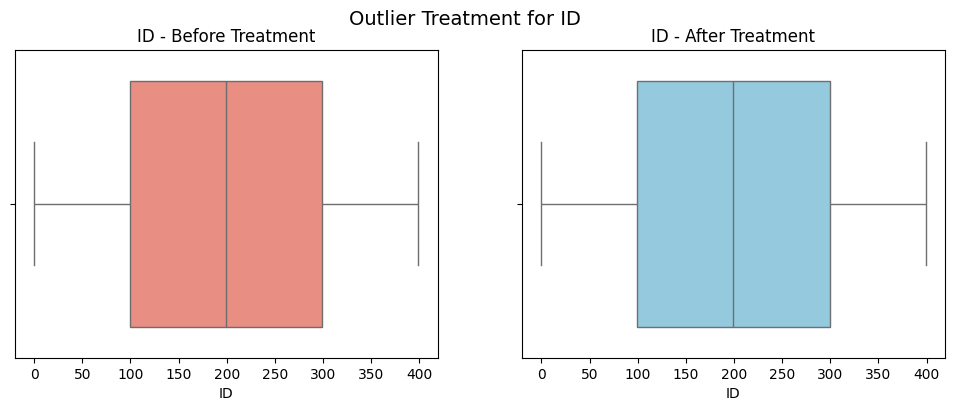

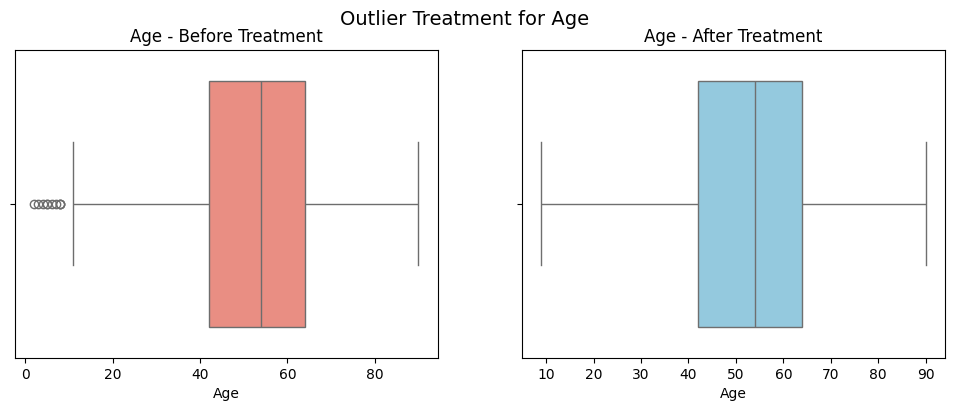

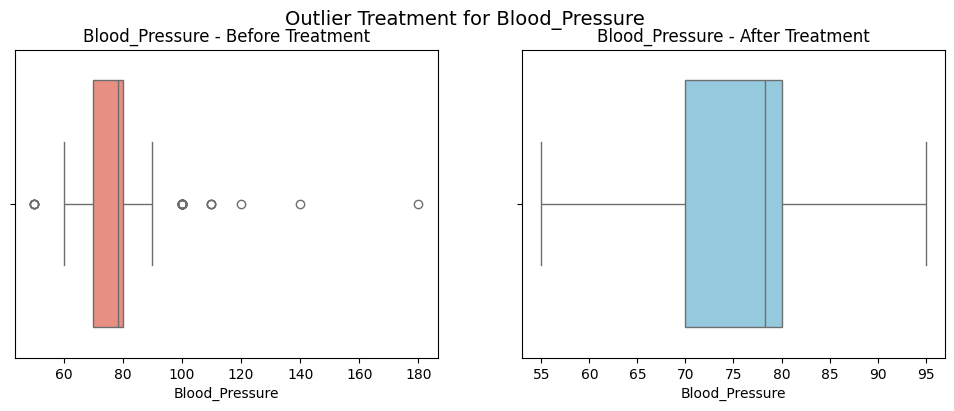

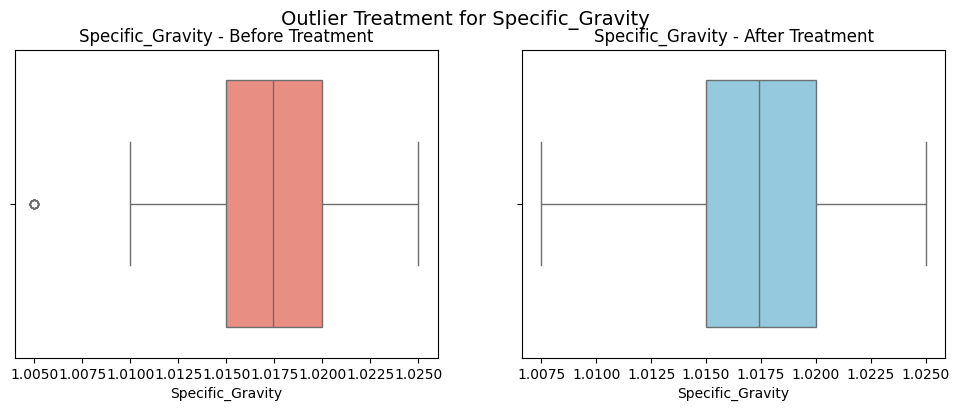

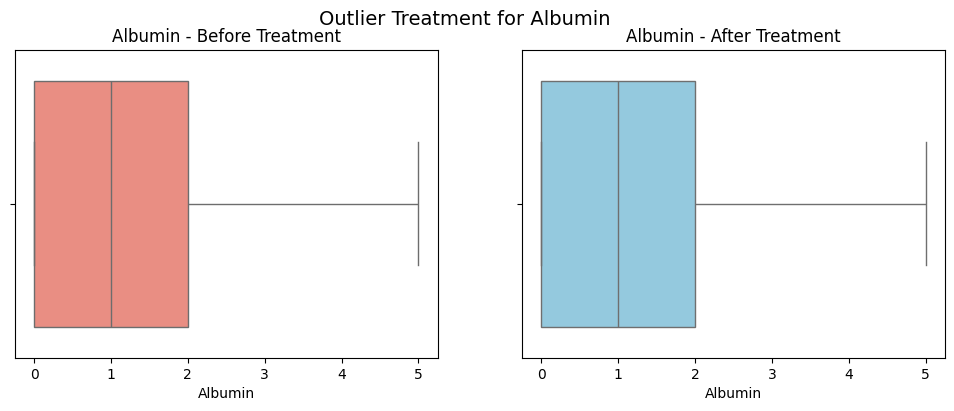

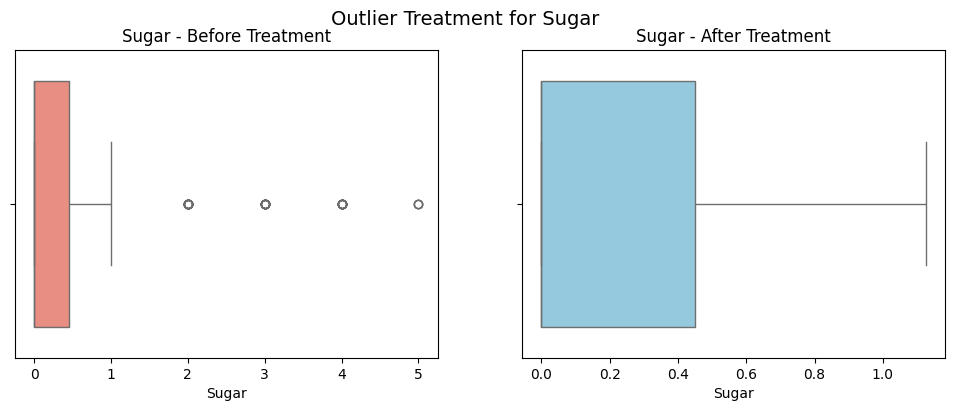

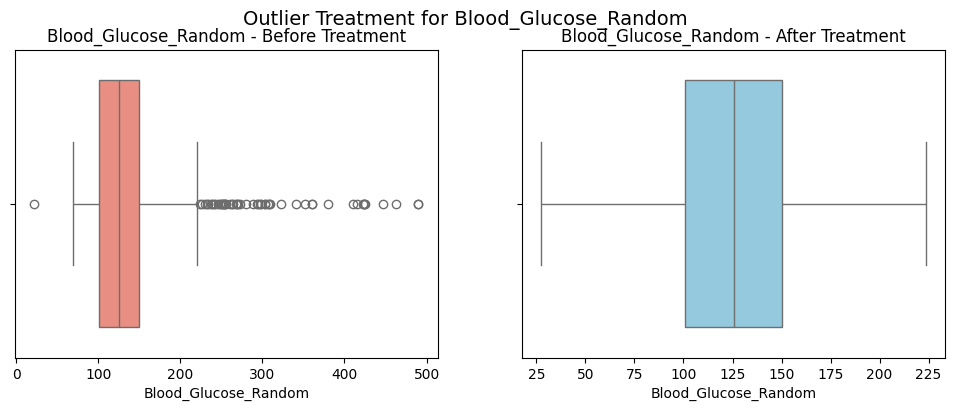

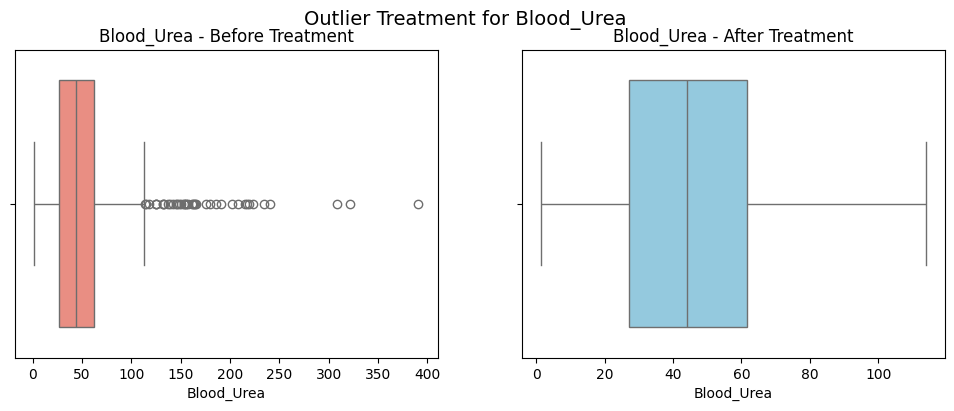

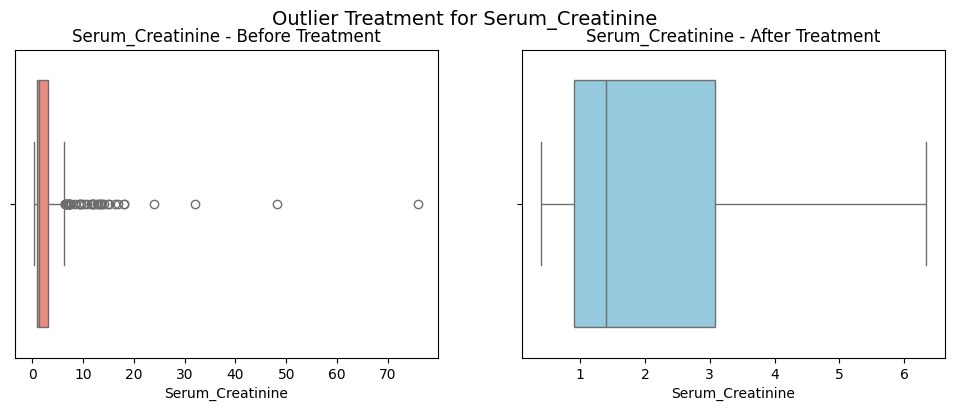

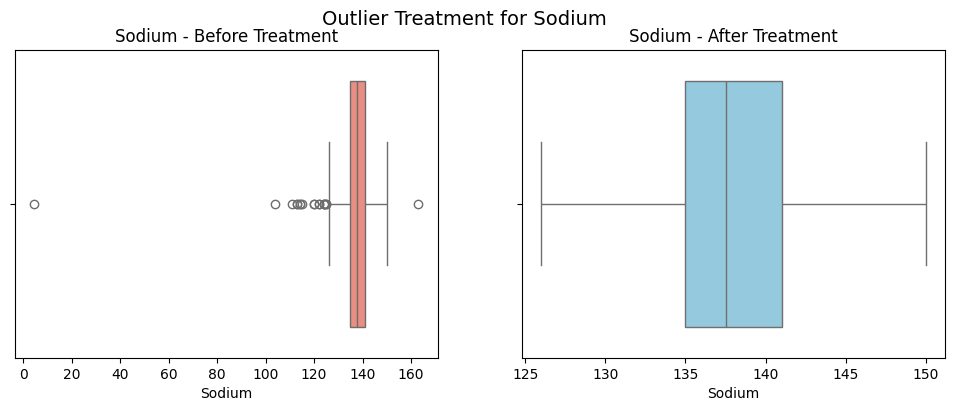

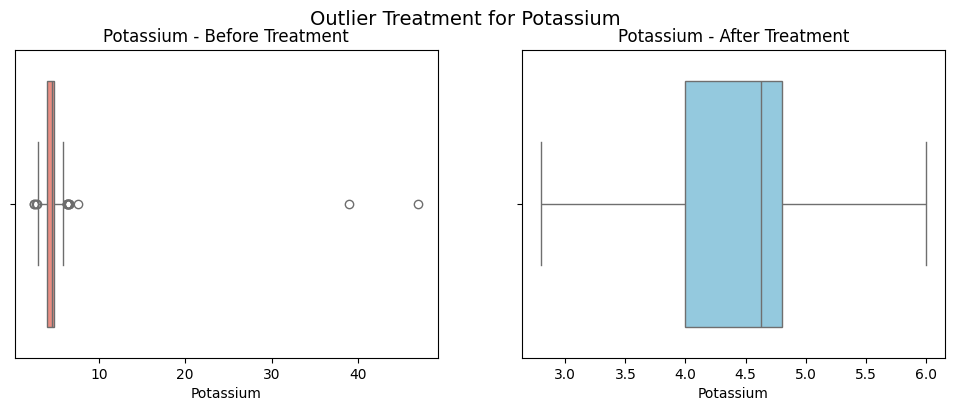

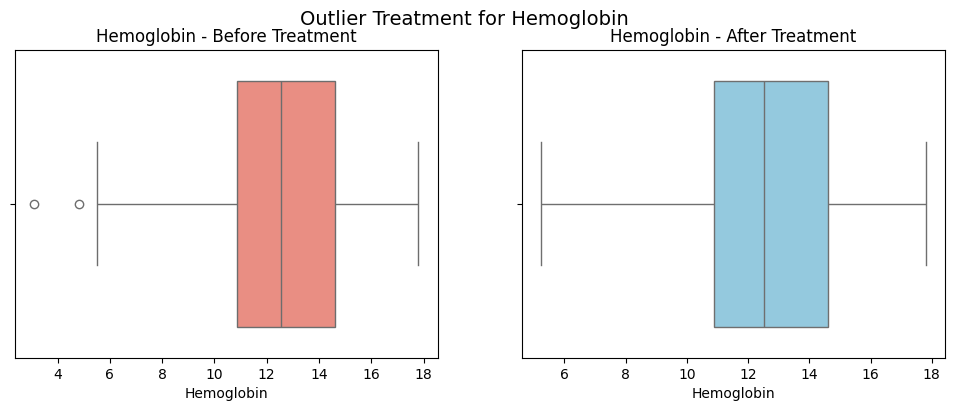

 Outlier treatment completed. Summary:

ID: Outliers Before = 0, After = 0
Age: Outliers Before = 10, After = 0
Blood_Pressure: Outliers Before = 36, After = 0
Specific_Gravity: Outliers Before = 7, After = 0
Albumin: Outliers Before = 0, After = 0
Sugar: Outliers Before = 48, After = 0
Blood_Glucose_Random: Outliers Before = 53, After = 0
Blood_Urea: Outliers Before = 41, After = 0
Serum_Creatinine: Outliers Before = 44, After = 0
Sodium: Outliers Before = 18, After = 0
Potassium: Outliers Before = 14, After = 0
Hemoglobin: Outliers Before = 2, After = 0


In [12]:
def treat_outliers_iqr(df, numerical_columns):
    """
    Detect and treat outliers using the IQR method.
    Outliers are capped at lower and upper bounds.
    Shows before/after plots for each numerical feature.
    """
    df_copy = df.copy()
    treated_cols = {}

    for col in numerical_columns:
        Q1 = df_copy[col].quantile(0.25)
        Q3 = df_copy[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers before treatment
        outliers_before = ((df_copy[col] < lower_bound) | (df_copy[col] > upper_bound)).sum()

        # Cap the outliers
        df_copy[col] = np.where(df_copy[col] < lower_bound, lower_bound, df_copy[col])
        df_copy[col] = np.where(df_copy[col] > upper_bound, upper_bound, df_copy[col])

        # Count outliers after treatment
        outliers_after = ((df_copy[col] < lower_bound) | (df_copy[col] > upper_bound)).sum()

        treated_cols[col] = {"Before": outliers_before, "After": outliers_after}

        # Plot before and after
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.boxplot(x=df[col], ax=axes[0], color="salmon")
        axes[0].set_title(f"{col} - Before Treatment")

        sns.boxplot(x=df_copy[col], ax=axes[1], color="skyblue")
        axes[1].set_title(f"{col} - After Treatment")

        plt.suptitle(f"Outlier Treatment for {col}", fontsize=14)
        plt.show()

    print(" Outlier treatment completed. Summary:\n")
    for col, stats in treated_cols.items():
        print(f"{col}: Outliers Before = {stats['Before']}, After = {stats['After']}")

    return df_copy


df_outlier_treated = treat_outliers_iqr(df_encoded, num_cols)


# Scaling numerical features

In [13]:
def scale_features(df, numerical_columns):
    """
    Scale numerical features using StandardScaler.
    Shows before/after mean and std for verification.
    """
    df_copy = df.copy()
    scaler = StandardScaler()

    # Save summary before scaling
    before_summary = df_copy[numerical_columns].agg(['mean', 'std']).T

    # Scale
    df_copy[numerical_columns] = scaler.fit_transform(df_copy[numerical_columns])

    # Save summary after scaling
    after_summary = df_copy[numerical_columns].agg(['mean', 'std']).T

    # Combine for comparison
    summary = before_summary.join(after_summary, lsuffix='_Before', rsuffix='_After')

    print(" Feature scaling completed. Mean & Std before vs after:\n")
    print(summary)

    # Preview scaled values
    print("\n Preview of scaled data:")
    print(df_copy[numerical_columns].head())

    return df_copy, scaler


df_scaled, scaler = scale_features(df_outlier_treated, num_cols)


 Feature scaling completed. Mean & Std before vs after:

                      mean_Before  std_Before    mean_After  std_After
ID                     199.500000  115.614301  7.105427e-17   1.001252
Age                     51.568376   16.748312  4.440892e-16   1.001252
Blood_Pressure          75.719072   10.947479  9.769963e-16   1.001252
Specific_Gravity         1.017452    0.005277  2.152944e-14   1.001252
Albumin                  1.016949    1.272318  7.105427e-17   1.001252
Sugar                    0.222685    0.400131 -5.329071e-17   1.001252
Blood_Glucose_Random   136.985267   46.028992  0.000000e+00   1.001252
Blood_Urea              51.010409   30.261358  1.776357e-16   1.001252
Serum_Creatinine         2.254129    1.861203  7.105427e-17   1.001252
Sodium                 138.115004    5.281317 -1.243450e-15   1.001252
Potassium                4.432744    0.643583  6.239453e-16   1.001252
Hemoglobin              12.532937    2.696409 -2.842171e-16   1.001252

 Preview of scaled 

#  Spliting the dataset

In [14]:
def split_dataset(X, y, test_size=0.3, random_state=23, stratify=True):
    """
    Split dataset into training and testing sets.

    Parameters:
    -----------
    X : DataFrame
        Feature matrix
    y : Series
        Target column
    test_size : float
        Proportion of dataset to include in test split (default 0.3)
    random_state : int
        Random seed for reproducibility (default 23)
    stratify : bool
        Whether to stratify split by y to preserve class distribution (default True)

    Returns:
    --------
    X_train, X_test, y_train, y_test : split datasets
    """
    stratify_param = y if stratify else None

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=stratify_param
    )

    print("Data split successfully!")
    print(f"- Training set: {X_train.shape[0]} rows")
    print(f"- Testing set:  {X_test.shape[0]} rows")
    print(f"- Features: {X_train.shape[1]}")
    print(f"- Test size fraction: {test_size}")

    return X_train, X_test, y_train, y_test

# Define features (X) and target (y)
X = df_scaled.drop("Classification", axis=1)
y = df_scaled["Classification"]

# Split data (after preprocessing)
X_train, X_test, y_train, y_test = split_dataset(X, y, test_size=0.3)

Data split successfully!
- Training set: 280 rows
- Testing set:  120 rows
- Features: 25
- Test size fraction: 0.3


# SMOTE Analysis

SMOTE applied on training set! Class distribution:

    Class  Original Count  Resampled Count
0     ckd             175              175
1  notckd             105              175


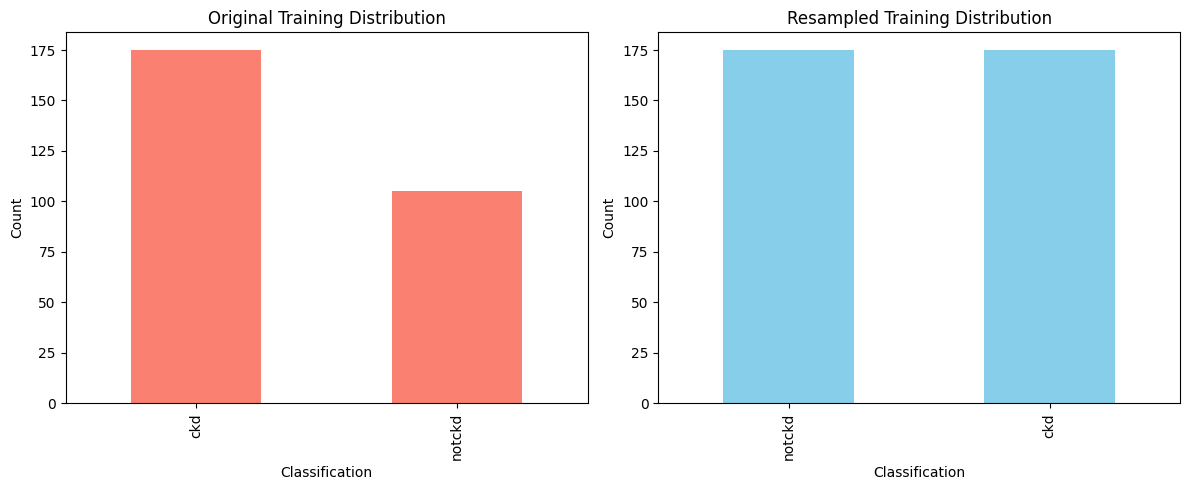

In [15]:
def apply_smote_train(X_train, y_train):
    """
    Apply SMOTE only on training data.
    Shows before/after class distributions and plots.
    """
    smote = SMOTE(random_state=23)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    # Summary
    original_counts = y_train.value_counts().reset_index()
    original_counts.columns = ["Class", "Original Count"]

    resampled_counts = pd.Series(y_resampled).value_counts().reset_index()
    resampled_counts.columns = ["Class", "Resampled Count"]

    summary_df = pd.merge(original_counts, resampled_counts, on="Class")
    print("SMOTE applied on training set! Class distribution:\n")
    print(summary_df)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    y_train.value_counts().plot(kind="bar", ax=axes[0], color="salmon")
    axes[0].set_title("Original Training Distribution")
    axes[0].set_ylabel("Count")

    pd.Series(y_resampled).value_counts().plot(kind="bar", ax=axes[1], color="skyblue")
    axes[1].set_title("Resampled Training Distribution")
    axes[1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

    return X_resampled, y_resampled, summary_df

# Apply SMOTE
X_train_resampled, y_train_resampled, smote_summary = apply_smote_train(X_train, y_train)


# Training multiple ML models


--- Logistic Regression ---
Classification Report:
              precision    recall  f1-score   support

         ckd       1.00      0.99      0.99        75
      notckd       0.98      1.00      0.99        45

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



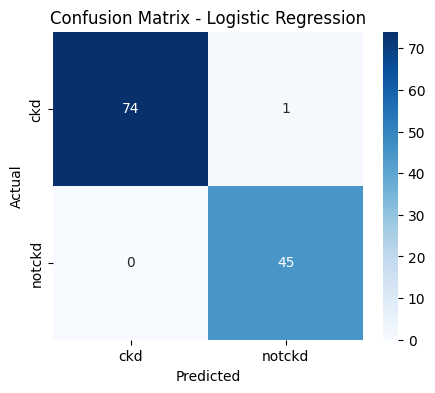

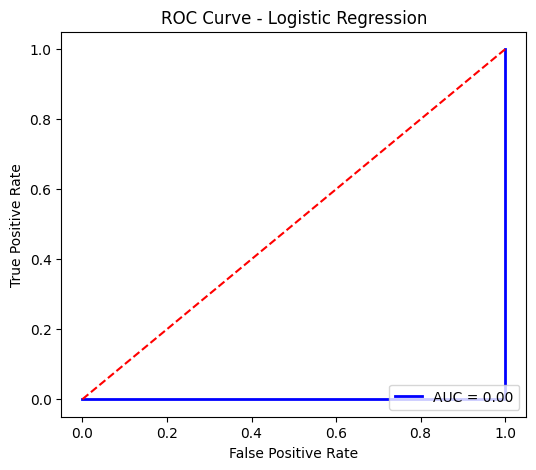

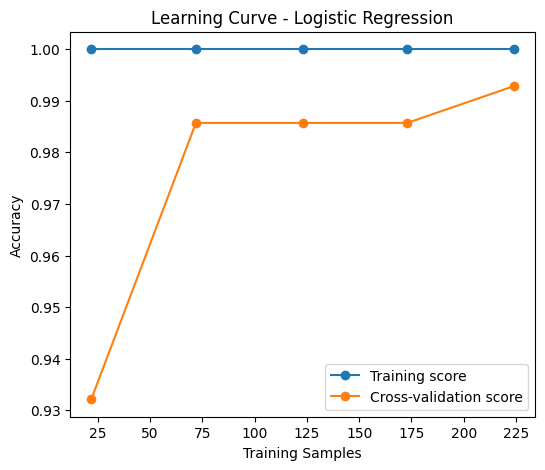


--- SVM ---
Classification Report:
              precision    recall  f1-score   support

         ckd       0.90      0.92      0.91        75
      notckd       0.86      0.82      0.84        45

    accuracy                           0.88       120
   macro avg       0.88      0.87      0.87       120
weighted avg       0.88      0.88      0.88       120



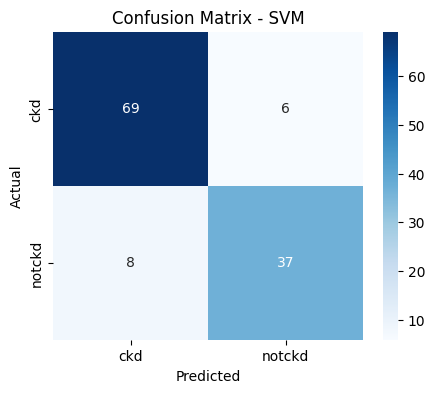

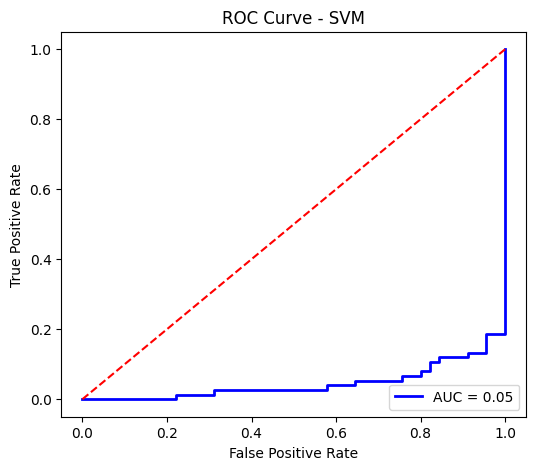

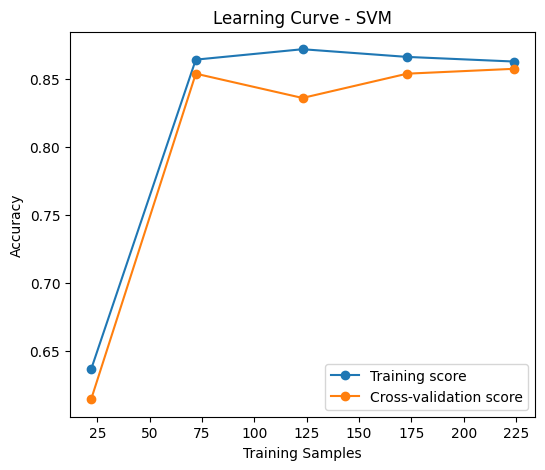


--- KNN ---
Classification Report:
              precision    recall  f1-score   support

         ckd       0.99      0.88      0.93        75
      notckd       0.83      0.98      0.90        45

    accuracy                           0.92       120
   macro avg       0.91      0.93      0.91       120
weighted avg       0.93      0.92      0.92       120



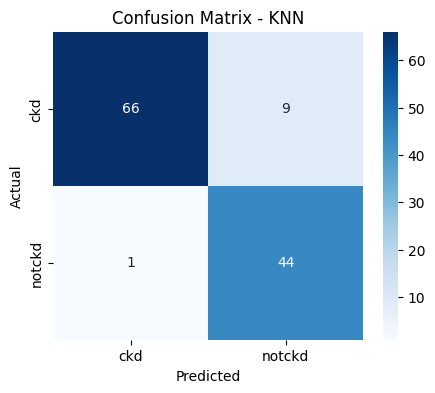

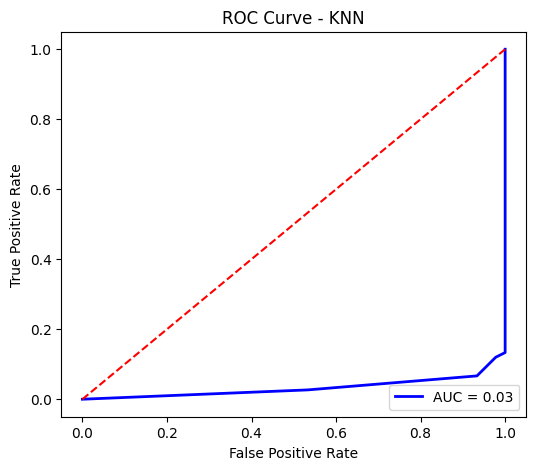

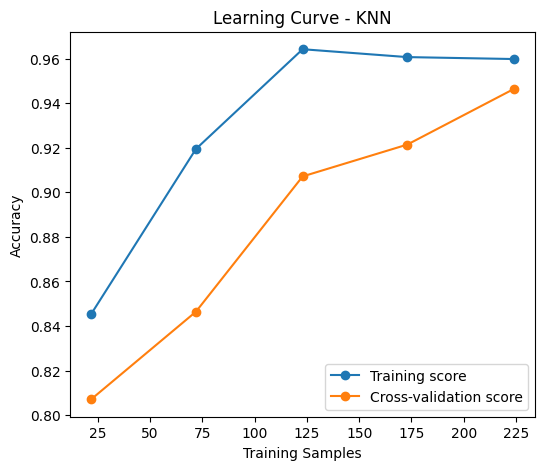


--- Naive Bayes ---
Classification Report:
              precision    recall  f1-score   support

         ckd       1.00      0.95      0.97        75
      notckd       0.92      1.00      0.96        45

    accuracy                           0.97       120
   macro avg       0.96      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



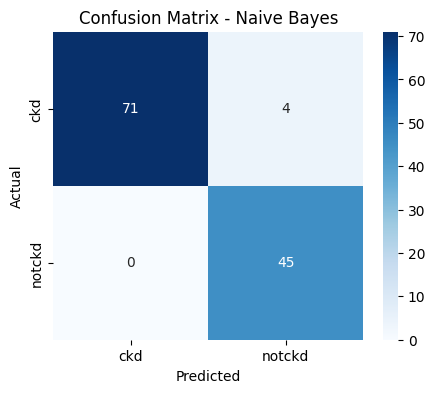

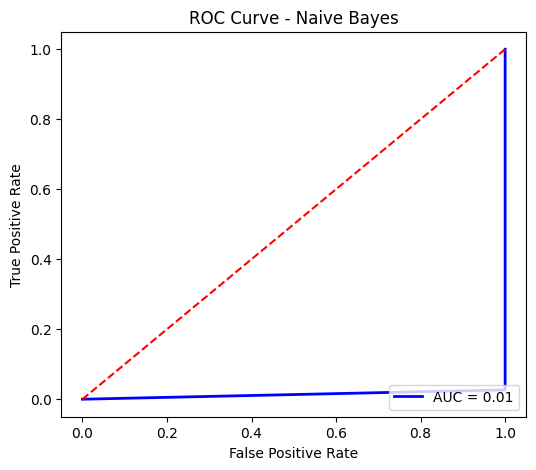

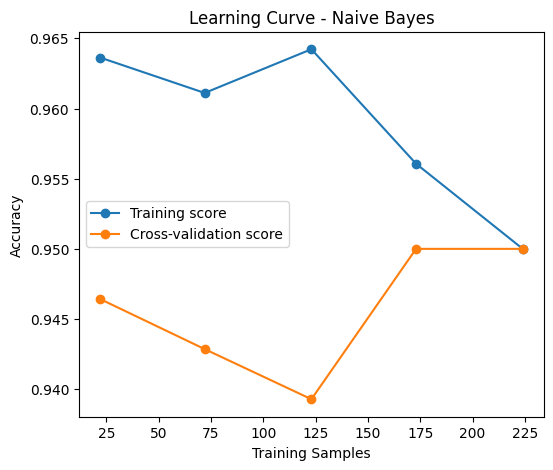


Model Comparison:
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.991667   1.000000  0.986667  0.993289
1                  SVM  0.883333   0.896104  0.920000  0.907895
2                  KNN  0.916667   0.985075  0.880000  0.929577
3          Naive Bayes  0.966667   1.000000  0.946667  0.972603


In [16]:

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=23),
    "SVM": SVC(probability=True, random_state=23),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

results = []

# --- Helper Functions ---
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

def plot_roc_curve(model, X_test, y_test, title, pos_label="ckd"):
    y_prob = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0,1], [0,1], color="red", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {title}")
    plt.legend(loc="lower right")
    plt.show()

def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring="accuracy", n_jobs=-1
    )
    train_mean = train_scores.mean(axis=1)
    test_mean = test_scores.mean(axis=1)

    plt.figure(figsize=(6,5))
    plt.plot(train_sizes, train_mean, "o-", label="Training score")
    plt.plot(train_sizes, test_mean, "o-", label="Cross-validation score")
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.title(f"Learning Curve - {title}")
    plt.legend()
    plt.show()

# --- Training & Evaluation ---
for name, model in models.items():
    print(f"\n--- {name} ---")

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Save metrics for comparison
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, pos_label="ckd"),
        "Recall": recall_score(y_test, y_pred, pos_label="ckd"),
        "F1-Score": f1_score(y_test, y_pred, pos_label="ckd")
    })

    # Plots
    plot_confusion_matrix(y_test, y_pred, name)
    plot_roc_curve(model, X_test, y_test, name, pos_label="ckd")
    plot_learning_curve(model, X_train, y_train, name)

# --- Comparison DataFrame ---
comparison_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(comparison_df)

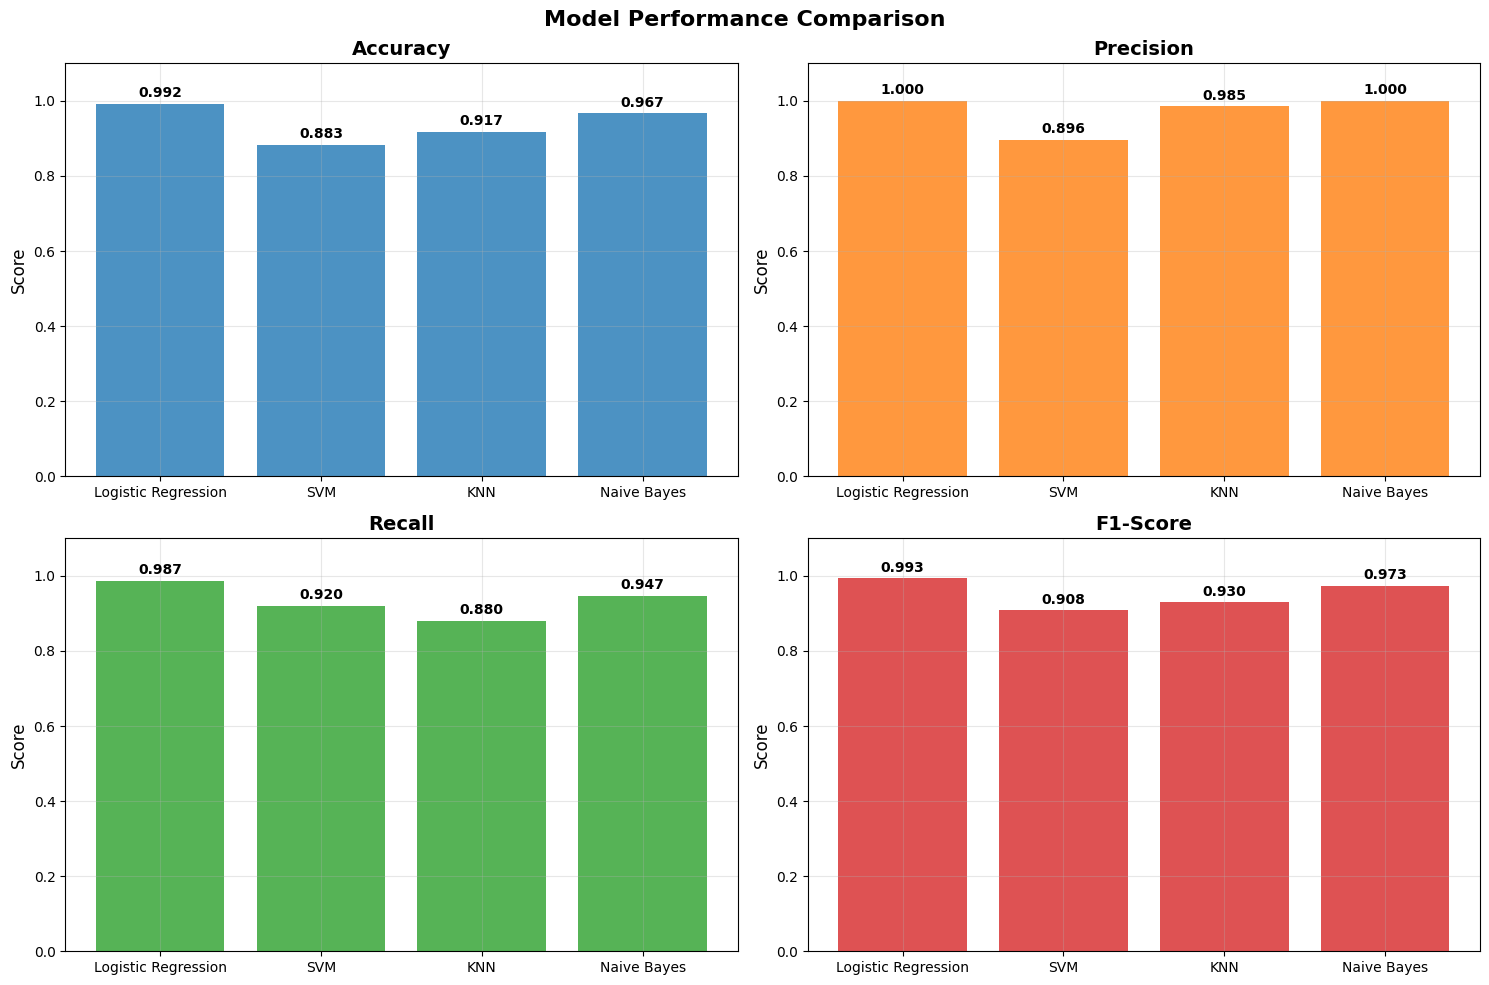

In [17]:
def plot_model_comparison_subplots(comparison_df):
    """
     visualization with separate subplots for each metric
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

    metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        bars = ax.bar(comparison_df["Model"], comparison_df[metric], color=colors[i], alpha=0.8)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

        ax.set_title(f'{metric}', fontsize=14, fontweight='bold')
        ax.set_ylim(0, 1.1)
        ax.set_ylabel('Score', fontsize=12)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
plot_model_comparison_subplots(comparison_df)

# Hyperparameter tuning



--- Logistic Regression ---
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Report:
               precision    recall  f1-score   support

         ckd       1.00      1.00      1.00        75
      notckd       1.00      1.00      1.00        45

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



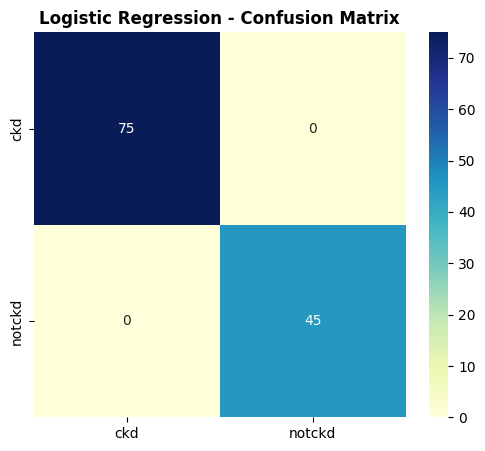


--- SVM ---
Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Report:
               precision    recall  f1-score   support

         ckd       1.00      0.99      0.99        75
      notckd       0.98      1.00      0.99        45

    accuracy                           0.99       120
   macro avg       0.99      0.99      0.99       120
weighted avg       0.99      0.99      0.99       120



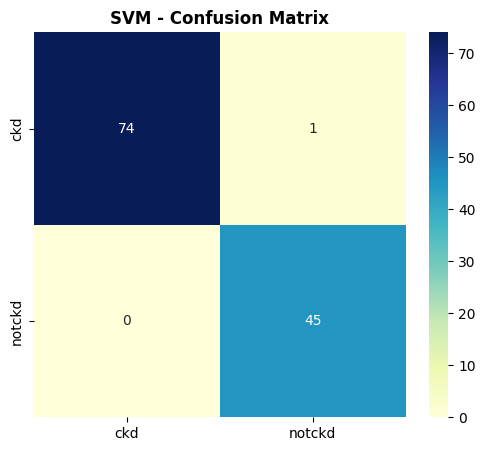


--- KNN ---
Best Params: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
Report:
               precision    recall  f1-score   support

         ckd       1.00      0.91      0.95        75
      notckd       0.87      1.00      0.93        45

    accuracy                           0.94       120
   macro avg       0.93      0.95      0.94       120
weighted avg       0.95      0.94      0.94       120



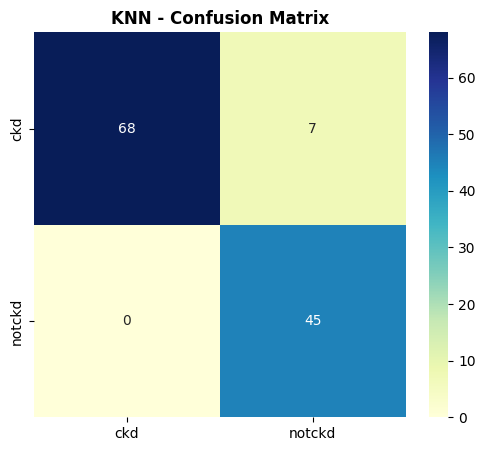


--- Naive Bayes ---
Best Params: {'var_smoothing': 1e-05}
Report:
               precision    recall  f1-score   support

         ckd       1.00      0.97      0.99        75
      notckd       0.96      1.00      0.98        45

    accuracy                           0.98       120
   macro avg       0.98      0.99      0.98       120
weighted avg       0.98      0.98      0.98       120



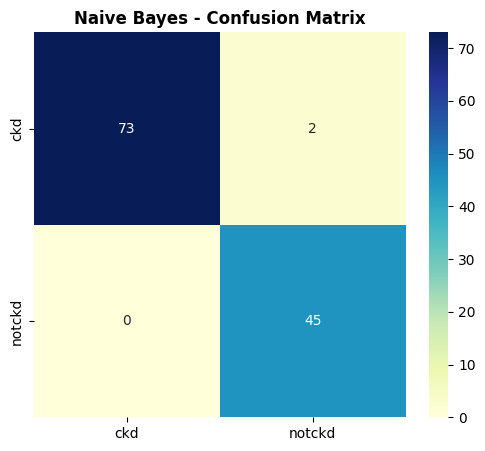

<Figure size 1200x600 with 0 Axes>

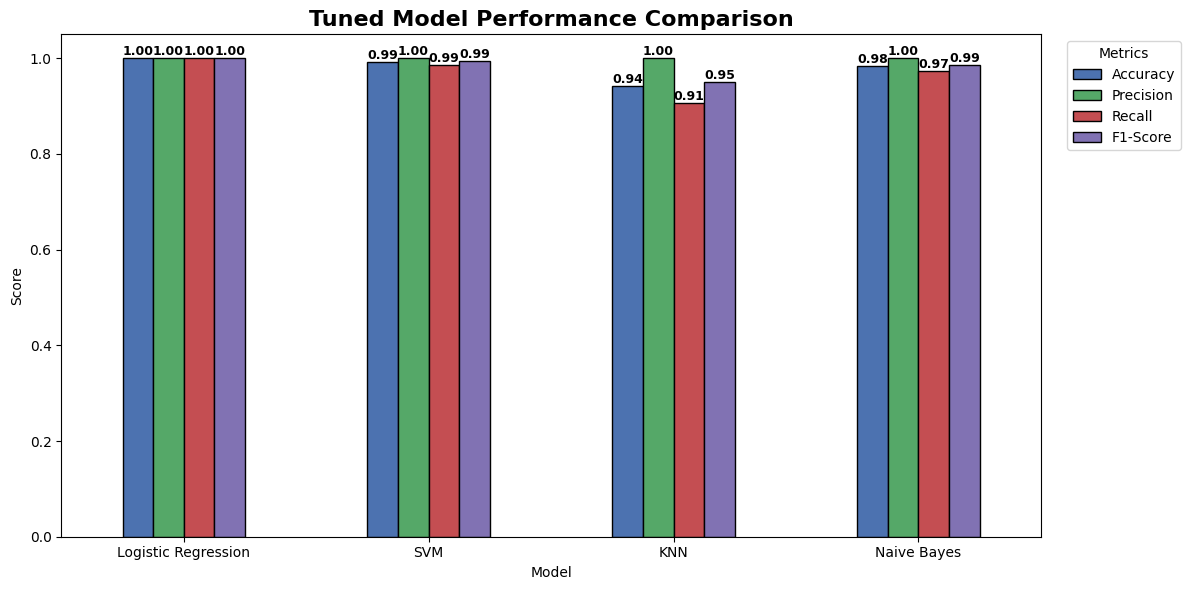

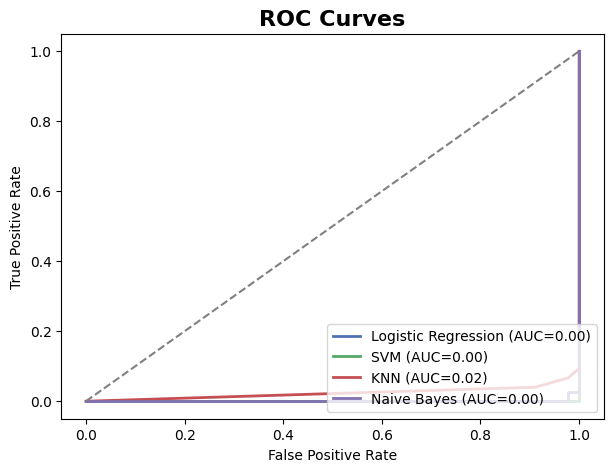

In [18]:
def tune_and_compare_models(X_train, X_test, y_train, y_test):
    # Models + Parameters
    models_params = {
        "Logistic Regression": (
            LogisticRegression(max_iter=1000, random_state=23),
            {"C": [0.01, 0.1, 1, 10], "solver": ["lbfgs", "liblinear"], "penalty": ["l1", "l2"]}
        ),
        "SVM": (
            SVC(probability=True, random_state=23),
            {"C": [0.01, 0.1, 1, 10], "kernel": ["linear", "rbf"], "gamma": ["scale", "auto"]}
        ),
        "KNN": (
            KNeighborsClassifier(),
            {"n_neighbors": [3, 5, 7], "weights": ["uniform", "distance"], "metric": ["euclidean", "manhattan"]}
        ),
        "Naive Bayes": (GaussianNB(), {"var_smoothing": [1e-9, 1e-7, 1e-5, 1e-3]})
    }

    results, all_roc = [], {}
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
    tuned_models = {} # Store best estimators for later use

    for name, (model, params) in models_params.items():
        print(f"\n--- {name} ---")
        if params:
            grid = GridSearchCV(model, params, cv=5, scoring="accuracy", n_jobs=-1)
            grid.fit(X_train, y_train)
            best_model = grid.best_estimator_
            best_params = grid.best_params_
        else:
            best_model = model.fit(X_train, y_train)
            best_params = "N/A"

        tuned_models[name] = best_model # Store the best estimator

        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)[:,1] if hasattr(best_model, "predict_proba") else None

        # Metrics
        acc, prec, rec, f1 = (
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred, pos_label="ckd"),
            recall_score(y_test, y_pred, pos_label="ckd"),
            f1_score(y_test, y_pred, pos_label="ckd"),
        )
        results.append({"Model": name, "Best Params": best_params,
                        "Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1})

        print("Best Params:", best_params)
        print("Report:\n", classification_report(y_test, y_pred))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred, labels=["ckd","notckd"])
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
                    xticklabels=["ckd","notckd"], yticklabels=["ckd","notckd"])
        plt.title(f"{name} - Confusion Matrix", weight="bold")
        plt.show()

        # ROC
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label="ckd")
            all_roc[name] = (fpr, tpr, auc(fpr, tpr))

    results_df = pd.DataFrame(results)

    # Bar Plot Comparison
    plt.figure(figsize=(12,6))
    colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B3"]
    ax = results_df.set_index("Model")[metrics].plot(
        kind="bar", figsize=(12,6), rot=0, color=colors, edgecolor="black"
    )
    plt.title("Tuned Model Performance Comparison", fontsize=16, weight="bold")
    plt.ylabel("Score"); plt.ylim(0, 1.05)
    plt.legend(title="Metrics", bbox_to_anchor=(1.02, 1), loc="upper left")

    # Add numbers on bars
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}",
                    (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', fontsize=9, weight="bold")

    plt.tight_layout(); plt.show()

    # ROC Curves Comparison
    plt.figure(figsize=(7,5))
    for (name, (fpr, tpr, roc_auc)), color in zip(all_roc.items(), colors):
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc:.2f})", color=color)
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.title("ROC Curves", fontsize=16, weight="bold")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right"); plt.show()

    return results_df, tuned_models # Return both results_df and tuned_models

tuned_results_df, tuned_models = tune_and_compare_models(X_train, X_test, y_train, y_test)

In [19]:
# Function to select the best model
def select_best_model(results_df, tuned_models, metric="F1-Score"):
    """
    Select the best model based on a given metric from results_df.

    Parameters:
        results_df (pd.DataFrame): DataFrame with metrics.
        tuned_models (dict): Dictionary of trained models from tuning.
        metric (str): Metric to optimize ("Accuracy", "Precision", "Recall", "F1-Score").

    Returns:
        best_name (str), best_model (fitted sklearn model)
    """
    best_row = results_df.loc[results_df[metric].idxmax()]
    best_name = best_row["Model"]
    best_model = tuned_models[best_name]
    print(f" Best Model: {best_name} with {metric} = {best_row[metric]:.4f}")
    return best_name, best_model


#  Function to save the model
def save_model(model, filepath="best_model.pkl"):
    joblib.dump(model, filepath)
    print(f" Model saved at {filepath}")
    return filepath


#  Function to load a saved model
def load_model(filepath="best_model.pkl"):
    model = joblib.load(filepath)
    print(f" Model loaded from {filepath}")
    return model


#  Function to predict on unseen data
def predict_unseen(model, new_data, expected_features=None, positive_label="ckd"):
    """
    Predict CKD on unseen data using a saved model.

    Parameters:
        model: Trained model (loaded via joblib).
        new_data (pd.DataFrame): Patient data.
        expected_features (list): Columns expected by the model.
        positive_label (str): Label considered as positive class.

    Returns:
        pd.DataFrame with predictions and probabilities.
    """
    # Ensure correct feature order
    if expected_features is not None:
        new_data = new_data.reindex(columns=expected_features, fill_value=0)

    pred = model.predict(new_data)
    prob = model.predict_proba(new_data)[:, 1]

    results = pd.DataFrame({
        "PredictedClass": [positive_label if p == "ckd" else "notckd" for p in pred],
        "Prob_Positive": prob
    })
    print(" Predictions on unseen data:")
    print(results)
    return results


In [20]:
# Select best model
best_name, best_model = select_best_model(tuned_results_df, tuned_models, metric="F1-Score")

# Save best model
save_path = save_model(best_model, filepath=f"best_ckd_model_{best_name.replace(' ','_').lower()}.pkl")

#  Load it back
clf = load_model(save_path)

# Prepare unseen patient data
new_patient = pd.DataFrame([{
    'Age': 55,
    'Blood Pressure': 75,
    'Specific Gravity': 2.030,
    'Albumin': 0,
    'Sugar': 1,
    'Blood Glucose Random': 125,
    'Blood Urea': 33,
    'Serum Creatinine': 0.3,
    'Sodium': 140,
    'Potassium': 3.0,
    'Hemoglobin': 15.0,
    'Packed Cell Volume': 43,
    'White Blood Cell Count': 3550,
    'Red Blood Cell Count': 3.0,
    'Hypertension': 0,
    'Diabetes Mellitus': 0,
    'Coronary Artery Disease': 1,
    'Appetite': 0,
    'Pedal Edema': 1,
    'Anemia': 0,
    'Red Blood Cells_normal': 0,
    'Pus Cell_normal': 0,
    'Pus Cell Clumps_present': 1,
    'Bacteria_present': 0
}])

# Step 5: Predict on unseen data
predictions = predict_unseen(clf, new_patient, expected_features=best_model.feature_names_in_, positive_label="ckd")

 Best Model: Logistic Regression with F1-Score = 1.0000
 Model saved at best_ckd_model_logistic_regression.pkl
 Model loaded from best_ckd_model_logistic_regression.pkl
 Predictions on unseen data:
  PredictedClass  Prob_Positive
0         notckd            1.0
